In [1]:
import dynamo as dyn
import pandas as pd
import numpy as np
import scipy
import scanpy as sc

import warnings

warnings.filterwarnings("ignore")


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


/Users/random/opt/anaconda3/envs/dynamo-dev/lib/python3.9/site-packages/nxviz/__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.3 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.3, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


In [2]:
adata_hsc_raw = dyn.read("./hsc_all_combined_all_layers.h5ad")
adata_hsc_raw


AnnData object with n_obs × n_vars = 2019 × 26193
    obs: 'batch'
    var: 'gene_name'
    layers: 'X_l_TC', 'X_n_TC', 'ambiguous', 'labeled_TC', 'sl_TC', 'sn_TC', 'spliced', 'total', 'ul_TC', 'un_TC', 'unlabeled_TC', 'unspliced'

In [3]:
adata_hsc_raw
adata_hsc_raw.obs_names_make_unique()


In [4]:
adata_processed = dyn.sample_data.hematopoiesis()
adata_processed.shape


|-----> Downloading processed hematopoiesis adata
|-----> Downloading data to ./data/hematopoiesis.h5ad


(1947, 1956)

In [5]:
adata_hsc_raw.obs["time"] = 3
adata_hsc_raw.obs.loc[adata_hsc_raw.obs.batch == "JL_10", "time"] = 5

adata_labeling = adata_hsc_raw[adata_processed.obs_names]
adata_labeling.layers["new"] = adata_labeling.layers["labeled_TC"].copy()
# adata_labeling.X = adata_labeling.layers['total'].copy()

layers_keys = adata_labeling.layers.keys()
for layer in ["X_l_TC", "X_n_TC", "ambiguous", "labeled_TC", "sl_TC", "sn_TC", "ul_TC", "un_TC", "unlabeled_TC"]:
    if layer in layers_keys:
        del adata_labeling.layers[layer]

In [6]:
# ZFPM1: FOG1; EKLF: KLF1; cJun: JUN; EgrNab: NAB2
# ETO2: CBFA2T3; TEL: ETV6
import pickle
union_genes = pickle.load(open("./union_genes.p", "rb"))

network_inference_genes = [
    "GATA2",
    "GFI1",
    "GFI1B",
    "NFE2",
    "TAL1",
    "GATA1",
    "LYL1",
    "ERG",
    "FLI1",
    "MEIS1",
    "SPI1",
    "MITF",
    "LMO2",
    "LDB1",
    "RUNX1",
    "ETV6",
    "HHEX",
    "CBFA2T3",
]
Krumsiek_11 = ["GATA2", "GATA1", "ZFPM1", "SPI1", "FLI1", "KLF1", "TAL1", "CEBPA", "GFI1", "JUN", "NAB2"]

union_genes += network_inference_genes
union_genes += Krumsiek_11

print(len(np.unique(union_genes)), len(union_genes))
# union_genes = np.unique(union_genes)


2552 2574


In [7]:
adata_labeling

AnnData object with n_obs × n_vars = 1947 × 26193
    obs: 'batch', 'time'
    var: 'gene_name'
    layers: 'spliced', 'total', 'unspliced', 'new'

In [8]:
dyn.pp.recipe_monocle(
    adata_labeling,
    tkey="time",
    experiment_type="one-shot",
    genes_to_use=union_genes,
    # genes_to_use=adata_processed.var_names,
    n_top_genes=len(union_genes),
    # feature_selection_layer="new",
    maintain_n_top_genes=True,
)
adata_labeling.var.use_for_pca.sum()


|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.
[ Future queries will be cached in "/Users/random/dynamo-notebooks/dynamo-hsc-process/mygene_cache.sqlite" ]
querying 1-1000...done. [ from cache ]
querying 1001-2000...done. [ from cache ]
querying 2001-3000...done. [ from cache ]
querying 3001-4000...done. [ from cache ]
query

1766

|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [15.3858s]
|-----------> plotting with basis key=X_umap


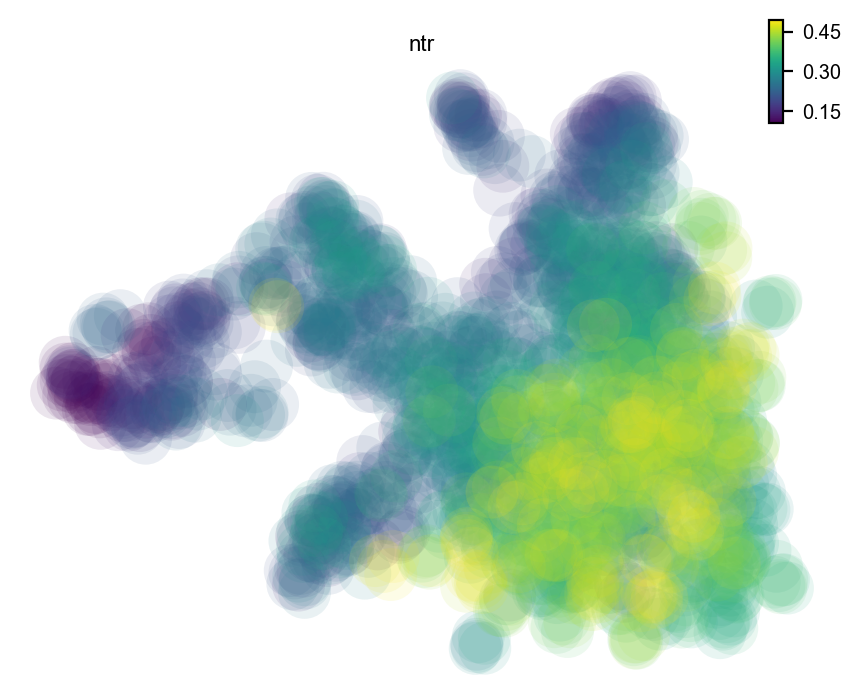

In [9]:
dyn.tl.reduceDimension(adata_labeling)
dyn.pl.umap(adata_labeling)

In [10]:
dyn.tl.moments(adata_labeling, group='time')
original_M_s = adata_labeling.layers['M_s'].copy()
M_u = adata_labeling.layers['M_u'].copy()

adata_labeling.uns["pp"]["has_splicing"] = False
# adata_labeling.obsm["X_umap"] = adata_processed.obsm["X_umap"].copy()
dyn.tl.dynamics(adata_labeling, group="time", one_shot_method="sci_fate", model="deterministic")

|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [10.7698s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? You used tkey time (or group time), but you have calculated local smoothing (1st moment) for your data before. Please ensure you used the desired tkey or group when the smoothing was performed. Try setting re_smooth = True if not sure.
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [3.2286s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████| 1766/1766 [00:00<00:00, 64976.63it/s]


|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [2.2993s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.


estimating alpha: 100%|██████████| 1766/1766 [00:00<00:00, 66709.36it/s]


AnnData object with n_obs × n_vars = 1947 × 20924
    obs: 'batch', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'gene_name', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'frac', 'ntr', 'time_3_alpha', 'time_3_beta', 'time_3_gamma', 'time_3_half_life', 'time_3_alpha_b', 'time_3_alpha_r2', 'time_3_gamma_b', 'time_3_gamma_r2', 'time_3_gamma_logLL', 'time_3_delta_b', 'time_3_delta_r2', 'time_3_bs', 'time_3_bf', 'time_3_uu0', 'time_3_ul0', 'time_3_su0', 'time_3_sl0', 'time_3_U0', 'time_3_S0', 'time_3_total0', 'time_3_beta_k', 'time_3_gamma_k', 'time_5_alpha', 'time_5_beta', 'time_5_gamma', 'time_5_half_life', 'time_5_alpha_b', 'time_5_alpha_

|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <insert> neighbors.params to uns in AnnData Object.
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] finished [7.8947s]
|-----> [

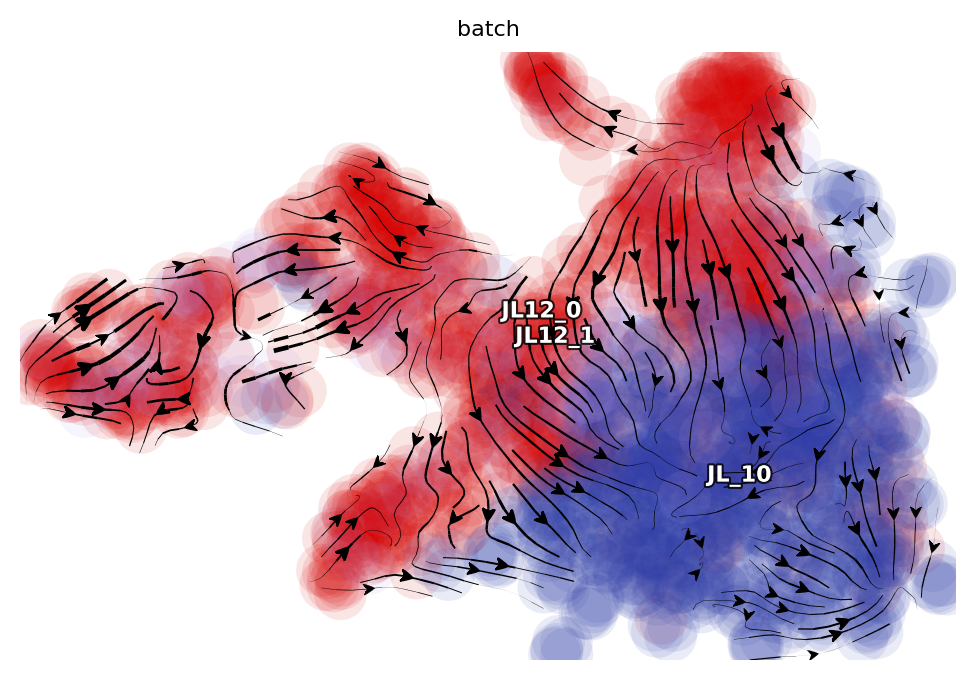

In [11]:

dyn.tl.cell_velocities(
    adata_labeling,
    enforce=True,
    method="cosine",
)
dyn.pl.streamline_plot(
    adata_labeling,
    color=['batch'], #+ list(adata_dyn.var_names.intersection(chen_paper_genes)),
    ncols=4,
    basis='umap',
)


In [13]:
# TODO: remove
chen_paper_genes = ["PLEK", "HBB", "MPO", "SPIB", "CD79A", "DNTT", "CD34", "CD164", "LMO4", "S100A8", "TGFBI"]


## Read and set HSC metadata

In [14]:
# TODO: replace csv results from leiden
labeling_obs_metadata = pd.read_csv("adata_labeling_all_combined_processed_final.csv", index_col=0)
labeling_obs_metadata.head()


,batch,time,cell_type,nGenes,nCounts,pMito,pass_basic_filter,new_Size_Factor,initial_new_cell_size,total_Size_Factor,...,pca_ddhodge_potential,umap_ori_ddhodge_div,umap_ori_ddhodge_potential,curl_umap_ori,divergence_umap_ori,control_point_umap_ori,inlier_prob_umap_ori,obs_vf_angle_umap_ori,n_counts,mt_frac
barcode,,,,,,,,,,,,,,,,,,,,,
CCACAAGCGTGC-JL12_0,JL12_0,3,Mon,1196,1944.0,0.114198,True,1.039024,852.0,1.227772,...,0.507833,-16.341991,1.792488,-0.046206,0.112111,False,0.999549,0.176351,3466.0,0.073572
CCATCCTGTGGA-JL12_0,JL12_0,3,Meg,1172,1706.0,0.067995,True,0.506098,415.0,1.002834,...,4.700147,41.514399,3.392540,0.098062,-0.273977,False,0.860345,0.354914,2831.0,0.048746
CCCTCGGCCGCA-JL12_0,JL12_0,3,Mon,663,915.0,0.044809,True,0.507317,416.0,0.718030,...,0.659788,-10.063857,1.593789,-0.017185,0.040728,False,0.999324,-0.352141,2027.0,0.024667
CCGCCCACCATG-JL12_0,JL12_0,3,Mon,2349,4739.0,0.138637,True,3.087805,2532.0,3.222813,...,0.609316,-15.608460,1.580450,0.110991,0.144292,False,0.999277,-0.449798,9098.0,0.086942
CCGCTGTGTAAG-JL12_0,JL12_0,3,MPP,1365,2140.0,0.077103,True,1.018293,835.0,1.231669,...,0.526728,-4.605920,1.269363,-0.040901,0.104698,False,0.999717,0.006409,3477.0,0.057521


In [15]:
adata_labeling.shape, labeling_obs_metadata.shape


((1947, 20924), (1947, 36))

In [16]:
obs_names = set(adata_labeling.obs_names).intersection(labeling_obs_metadata.index)
obs_names = list(obs_names)
# adata_labeling = adata_labeling[obs_names, :]


In [17]:
adata_labeling.obs["cell_type"] = np.nan
adata_labeling.obs["cell_type"][obs_names] = list(labeling_obs_metadata.loc[obs_names, "cell_type"])


In [18]:
adata_labeling.obs["cell_type"].unique()


array(['Mon', 'Meg', 'MPP', 'Ery', 'Bas', 'GMP', 'HSC', 'Neu'],
      dtype=object)

In [19]:
adata_labeling.obs["cell_type"] = adata_labeling.obs["cell_type"].map(
    {
        "GMP": "GMP-like",
        "MPP": "MEP-like",
        "Mon": "Mon",
        "Meg": "Meg",
        "Ery": "Ery",
        "Bas": "Bas",
        "HSC": "HSC",
        "Neu": "Neu",
    }
)

adata_labeling.obs["cell_type"].value_counts()


MEP-like    457
Mon         423
HSC         309
Ery         234
Bas         177
GMP-like    161
Meg         154
Neu          32
Name: cell_type, dtype: int64

## Velocity correction

In [20]:
adata_labeling.obs.time.unique()


array([3, 5])

|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via cosine kernel with sqrt transform.] finished [131.3225s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.3813s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering batch by stack threshold when stacking color because it is not a numeric type


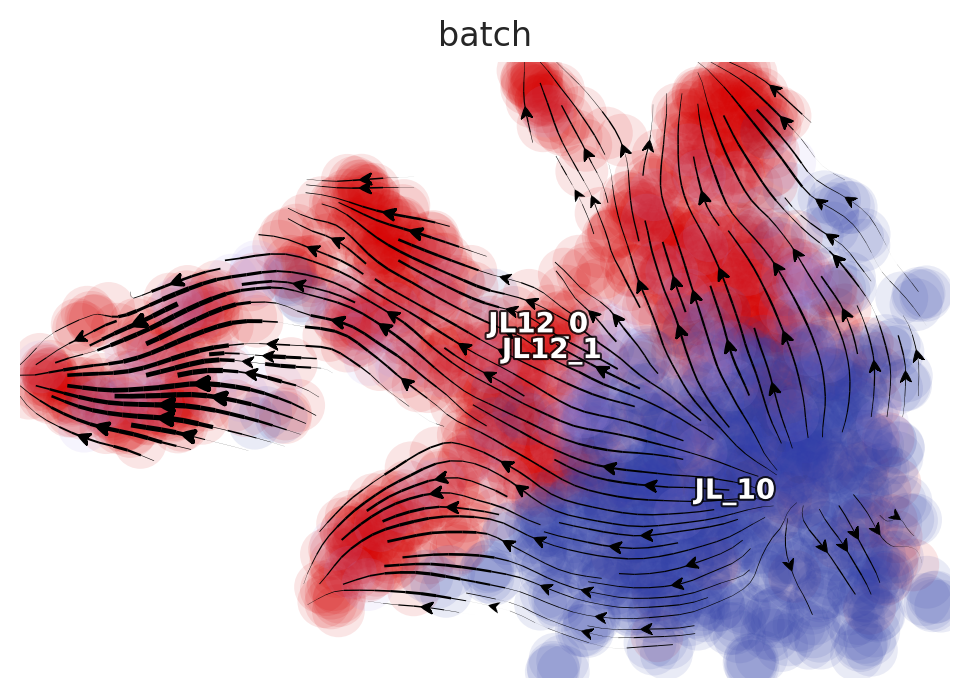

In [21]:
#############################################
# alpha = new / (1 - e^{-rt}) * r
#############################################
new = adata_labeling[:, adata_labeling.var.use_for_pca].layers['M_n']
gamma = adata_labeling[:, adata_labeling.var.use_for_pca].var.gamma
time_3_gamma = adata_labeling[:, adata_labeling.var.use_for_pca].var.time_3_gamma.astype(float)
time_5_gamma = adata_labeling[:, adata_labeling.var.use_for_pca].var.time_5_gamma.astype(float)

t = adata_labeling.obs.time.astype(float)
M_s = original_M_s[:, adata_labeling.var.use_for_pca]

time_3_cells = adata_labeling.obs.time == 3
time_5_cells = adata_labeling.obs.time == 5

def alpha_minus_gamma_s(new, gamma, t, M_s):
    alpha = new.A.T / (1 - np.exp(- gamma.values[:, None] * t.values[None, :])) * gamma.values[:, None]
    gamma_s = gamma.values[:, None] * M_s.A.T
    alpha_minus_gamma_s = alpha - gamma_s

    return alpha_minus_gamma_s

time_3_tmp = alpha_minus_gamma_s(new[time_3_cells, :], time_3_gamma, t[time_3_cells], M_s[time_3_cells, :])
time_5_tmp = alpha_minus_gamma_s(new[time_5_cells, :], time_5_gamma, t[time_5_cells], M_s[time_5_cells, :])

tmp = adata_labeling.layers['velocity_N'].copy()

valid_tmp = tmp[:, adata_labeling.var.use_for_pca].copy()
valid_tmp[time_3_cells, :] = time_3_tmp.T
valid_tmp[time_5_cells, :] = time_5_tmp.T
tmp[:, adata_labeling.var.use_for_pca] = valid_tmp.copy()

adata_labeling.layers['velocity_alpha_minus_gamma_s'] = tmp.copy()

dyn.tl.cell_velocities(adata_labeling,
                       enforce=True,
                       X=adata_labeling.layers['M_t'],
                       V=adata_labeling.layers['velocity_alpha_minus_gamma_s'],
                       method='cosine',
                       )

chen_paper_genes = ['PLEK', 'HBB', 'MPO', 'SPIB', 'CD79A', 'DNTT', 'CD34', 'CD164', "LMO4", "S100A8", "TGFBI"]
dyn.pl.streamline_plot(
    adata_labeling,
    color=['batch'] + list(adata_hsc_raw.var_names.intersection(chen_paper_genes)),
    ncols=4,
    basis='umap',
)

|-----------> plotting with basis key=X_umap
|-----------> skip filtering batch by stack threshold when stacking color because it is not a numeric type


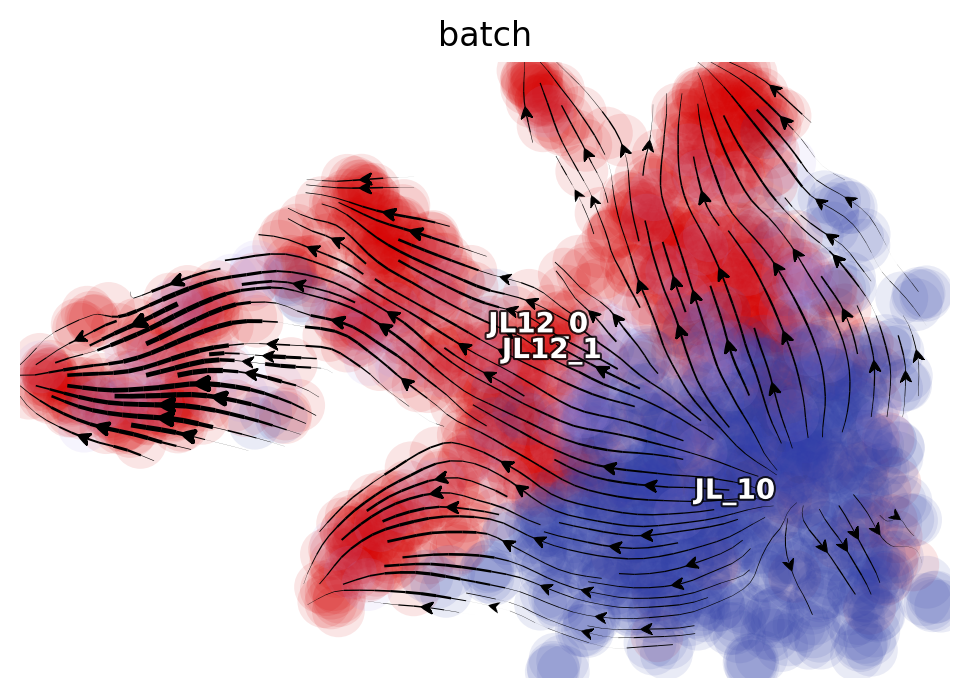

In [22]:

chen_paper_genes = ["PLEK", "HBB", "MPO", "SPIB", "CD79A", "DNTT", "CD34", "CD164", "LMO4", "S100A8", "TGFBI"]
dyn.pl.streamline_plot(
    adata_labeling,
    color=['batch'] + list(adata_hsc_raw.var_names.intersection(chen_paper_genes)),
    ncols=4,
    basis='umap',
)


In [23]:
sum(adata_labeling.var["use_for_pca"])

1766

In [24]:
old_umap = adata_labeling.obsm["X_umap"]

|-----> 0 genes are removed because of nan velocity values.
Using existing cosine_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [0.5189s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering batch by stack threshold when stacking color because it is not a numeric type


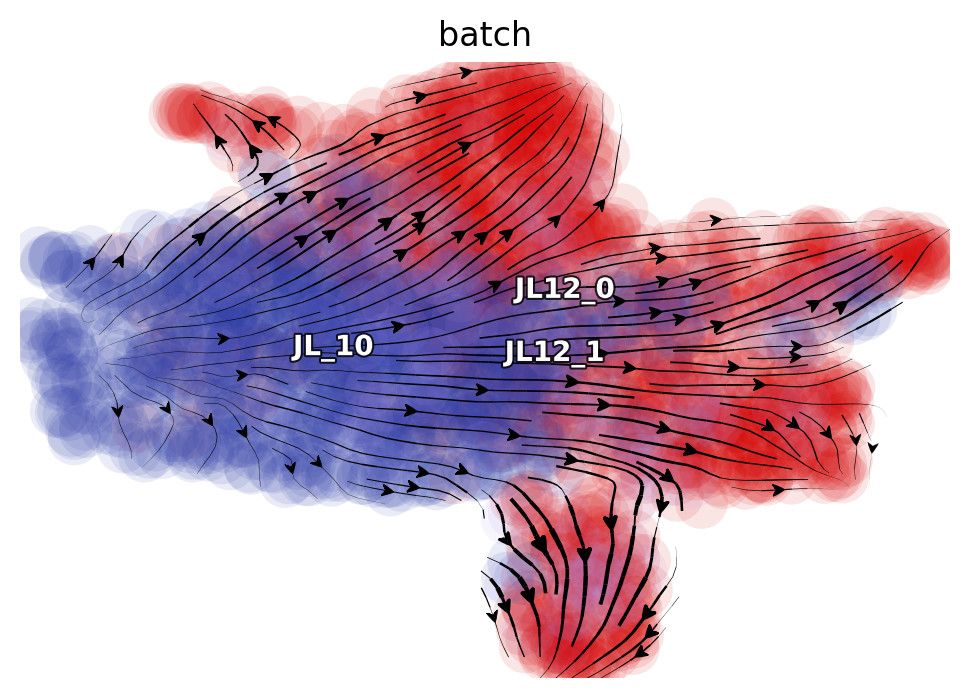

In [26]:
# reorder adata_labeling indexing
adata_labeling.obsm['X_umap'] = adata_processed[adata_labeling.obs_names, :].obsm['X_umap'].copy()
dyn.tl.cell_velocities(adata_labeling,
                       # X=adata_labeling.layers['M_t'],
                       # V=adata_labeling.layers['alpha_minus_gamma_s'],
                       basis='umap',
                       method='cosine',
                       # enforce=True,
                       )

dyn.pl.streamline_plot(
    adata_labeling,
    color=['batch'], #+ list(adata_dyn.var_names.intersection(chen_paper_genes)),
    ncols=4,
    basis='umap',
)